In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from keras.models import Sequential
from keras.layers import Dense

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

#import statsmodels.api as sm,

import seaborn as sns; sns.set()

from pandas.core import datetools
%matplotlib inline


Using TensorFlow backend.


# Data Acquisition
The following code imports and validates the LendingClub data.

In [2]:
converters = dict(
    id=str,
    desc=str,
    hardship_type=str,
    hardship_reason=str,
    hardship_status=str,
    hardship_loan_status=str,
    verification_status_joint=str
)
dates = [
    'next_pymnt_d',
    'hardship_start_date',
    'hardship_end_date',
    'payment_plan_start_date',
    'earliest_cr_line',
    'issue_d'
]

In [3]:
# Imports loan data

df = pd.DataFrame()
basepath='./Source Data/Loan Data/'
files = os.listdir(basepath)
csvs = []

for file in files:
    if re.match('.*csv$',file):
        csvs += [file]

if 0:
    #ignore this - was trying to pickle the data into
    #formats like feather, hdf5, native python pickling, etc
    # but found issues on python 3.7
    df=pd.read_pickle(basepath+'df.pkl')
else:
    cols = df.dtypes
    for csv in csvs:
        path = basepath + csv
        print("Reading",path)
        tdf = pd.read_csv(path,header=1,low_memory=False)
        df=df.append(tdf)
    
df.reset_index(inplace=True) # This will help with joining back data if necessary.

print(df.shape)

Reading ./Source Data/Loan Data/LoanStats3a_securev1.csv
Reading ./Source Data/Loan Data/LoanStats3b_securev1.csv
Reading ./Source Data/Loan Data/LoanStats3c_securev1.csv
Reading ./Source Data/Loan Data/LoanStats3d_securev1.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2016Q1.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2016Q2.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2016Q3.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2016Q4.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2017Q1.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2017Q2.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2017Q3.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2017Q4.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2018Q1.csv
(1873317, 152)


In [4]:
pd.set_option('display.max_rows', 200)
print(df.dtypes)
pd.set_option('display.max_rows', 200)

index                                           int64
id                                             object
member_id                                     float64
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                       object
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                  

In [5]:
# Checks for duplicates within our combined data
df['count']=1 # Generate field to measure the number of occurances

counts = df.groupby('id')['count'].count()
print('Data are duplicated %i times.' % len(counts[counts>1]))

Data are duplicated 0 times.


Data are duplicated 0 times.

Some data are not useful as a predictor. Because we are going to use these data as a training set, we need to remove data that are not useful for predictions. There are two categories of data that are not useful for predictions. First, we need information about loans that have fully run their course. That is to say, we need to see loans that have either been paid in full or written off. It is not useful to see loans that are currently delinquent or current on payments but still early in the loan. Second, we need to remove predictors that are not import for predicting the loan. For example the URL has no impact on the borrower's ability to repay the loan. If we need this data in the future, we can still pair it back with the original dataframe.

In [6]:
has_data = {}
for column in df.columns:
    has_data[column] = len(df[column].dropna())
#print(len(has_data))
#has_data

order_has_data=sorted(has_data, key=lambda dict_key: has_data[dict_key])

top_sparse=50
for i,j in zip(order_has_data[0:top_sparse],range(top_sparse)):
    print(j, i, has_data[i])

0 member_id 0
1 orig_projected_additional_accrued_interest 5846
2 hardship_type 7288
3 hardship_reason 7288
4 hardship_status 7288
5 deferral_term 7288
6 hardship_amount 7288
7 hardship_start_date 7288
8 hardship_end_date 7288
9 payment_plan_start_date 7288
10 hardship_length 7288
11 hardship_dpd 7288
12 hardship_loan_status 7288
13 hardship_payoff_balance_amount 7288
14 hardship_last_payment_amount 7288
15 sec_app_mths_since_last_major_derog 18992
16 debt_settlement_flag_date 21652
17 settlement_status 21652
18 settlement_date 21652
19 settlement_amount 21652
20 settlement_percentage 21652
21 settlement_term 21652
22 sec_app_revol_util 54417
23 revol_bal_joint 55366
24 sec_app_fico_range_low 55367
25 sec_app_fico_range_high 55367
26 sec_app_earliest_cr_line 55367
27 sec_app_inq_last_6mths 55367
28 sec_app_mort_acc 55367
29 sec_app_open_acc 55367
30 sec_app_open_act_il 55367
31 sec_app_num_rev_accts 55367
32 sec_app_chargeoff_within_12_mths 55367
33 sec_app_collections_12_mths_ex_med 5

Based on the data, it appears that joint applications are a fairly new development in these data. We see only about 50,000 instances where the data are included for joint applications. The following visualization shows the relationship for income in joint applicants.

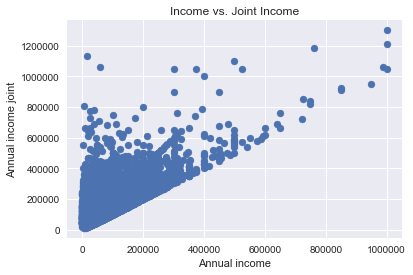

In [7]:
joint_fil = (df['annual_inc']>0)&(df['annual_inc_joint']>0)
plt.scatter(df[joint_fil]['annual_inc'],df[joint_fil]['annual_inc_joint'])
plt.title('Income vs. Joint Income')
plt.xlabel('Annual income')
plt.ylabel('Annual income joint')
plt.show;


Because of the high risk of multicolinearity, and the small number of observations, we are dropping this from the dataset. We will still keep a dummy variable that treats joint applications differently, but we will not consider the joint income of applicants.

In [8]:
# Convert dates to datetime
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])

#determine age of credit line prior to loan issue and convert to integer
# days of credit history
df['earliest_cr_line'] = (df['issue_d']-df['earliest_cr_line']).dt.days

# convert issue_d to a year to consider economic conditions
#SHOULD WE GO TO QUARTERS?
df['issue_d'] = df['issue_d'].dt.year

In [9]:
# Limit to loans that are paid in full or written off. Uses dates so that 
# loans that are delinquent are not disproportionaltely dropped from data

mature_filter = (df['loan_status']=='Fully Paid')|(df['loan_status']=='Charged Off')
#latest_mature = df[~mature_filter]['issue_d'].min()
#latest_mature
#reduced_df = df[df['issue_d']<=latest_mature]
reduced_df = df[mature_filter] # Pulls only loans that are charged off or paid in full.
#
## Use my documentation to filter to only 
data_dict = pd.read_excel('./Source Data/LCDataDictionary.xlsx',sheet_name='LoanStats')
features = list(data_dict[data_dict['Useful Predictor']=='Yes']['LoanStatNew'].values)
reduced_df=reduced_df[features]

# Combines fields when necessary
reduced_df['fico_est'] = (reduced_df['fico_range_low']+reduced_df['fico_range_high'])/2

reduced_df.drop(columns=['fico_range_low','fico_range_high'],inplace=True)
print(reduced_df.shape)

(1020552, 70)


In [10]:
# backup our df
backup_df = reduced_df.copy()

In [11]:
#restore our df
reduced_df = backup_df.copy()

In [12]:
# Convert strings to numbers emp_length, int_rate, revol_util
emp_length_map={'10+ years':10, '< 1 year':0, '1 year':1, '3 years':3, '8 years':8, '9 years':9,
                '4 years':4, '5 years':5, '6 years':6, '2 years':2, '7 years':7}

reduced_df['emp_length']=reduced_df['emp_length'].replace(pd.Series(emp_length_map))

grade_map={"A":1,"B":2,"C":3,"D":4,"E":5,"F":6,"G":7}
reduced_df['grade']=reduced_df['grade'].replace(pd.Series(grade_map))

reduced_df['int_rate']=reduced_df['int_rate'].apply(lambda x: float(x[:-1]))
reduced_df['revol_util']=reduced_df['revol_util'].apply(lambda x:
                                                        x[:-1] if isinstance(x, str) else np.nan).astype(float)

reduced_df['earliest_cr_line']=reduced_df['earliest_cr_line'].apply(lambda x:
                                                        0.0 if np.isnan(x) else x)

reduced_df.drop(columns=['emp_title'],inplace=True)

print(reduced_df.shape)

(1020552, 69)


# Which values are categorical?

In [13]:
n_options = {}
for column in reduced_df.columns:
    n_options[column] = len(reduced_df[column].unique())
#n_options
order_n_options=sorted(n_options, key=lambda dict_key: n_options[dict_key])

for i in order_n_options[0:50]:
    print(i, n_options[i],reduced_df[i].unique())

application_type 2 ['Individual' 'Joint App']
term 2 [' 36 months' ' 60 months']
verification_status 3 ['Verified' 'Source Verified' 'Not Verified']
home_ownership 6 ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' 'ANY']
grade 7 [2 3 1 5 6 4 7]
inq_last_6mths 10 [ 1.  5.  2.  0.  3.  4.  6.  7.  8. nan]
chargeoff_within_12_mths 11 [ 0. nan  1.  2.  3.  4.  5.  7.  6. 10.  8.]
emp_length 12 [10.  0.  1.  3.  8.  9.  4.  5.  6.  2.  7. nan]
issue_d 12 [2011. 2010. 2009. 2008. 2007. 2013. 2012. 2014. 2015. 2016. 2017. 2018.]
pub_rec_bankruptcies 13 [ 0.  1.  2. nan  4.  3.  8.  5.  6.  7. 12.  9. 11.]
purpose 14 ['credit_card' 'car' 'small_business' 'other' 'wedding'
 'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
 'moving' 'vacation' 'house' 'renewable_energy' 'educational']
collections_12_mths_ex_med 15 [ 0. nan  1.  2.  4.  3.  6. 16. 20.  5. 10. 14.  7. 12.  9.]
open_il_12m 19 [nan  0.  2.  1.  3.  4.  6.  5.  9.  7.  8. 10. 12. 11. 13. 14. 20. 21.
 25.]
open_acc_6m 20 [na

mths_since_rcnt_il 301 [ nan  16.   6.   5.   9.   3.  19.  14.   2.   7.  47.  21.  17.  52.
  25.   8.  62.  11.  18.  91.  64.  24.  23.  45.  13.  55.  10.  50.
  43.  12.  35.   1.  27. 338. 141.  89.   4. 103.  59.  31.  38.  54.
  26.  28.  32.  34. 118.  63.  15. 121.  20. 275.  41.  36. 100.  29.
  46.  22.  39.  71. 119.  30. 145.  77.  61. 129.  67.  49.  57.  74.
  40.  93.  37.  44. 115.  79. 101.  42. 114.  33.  90.  60. 230. 151.
 131.  68.  85.  82. 117. 113.  48.  81.  95.  80.  56. 135. 158. 288.
 152.  69.  83.  86.  51.  88. 111.  94. 107. 149.  98.  97. 140. 112.
 147.   0.  92.  73.  84.  99. 138.  76.  65.  66. 123. 122. 125.  70.
 139.  72.  78. 144. 134.  53.  96. 124. 108. 202. 127. 242.  75. 102.
  87.  58. 153. 106. 165. 208. 174. 181. 137. 128. 110. 105. 185. 130.
 132. 175. 191. 116. 104. 244. 172. 120. 161. 148. 126. 146. 166. 207.
 201. 173. 219. 211. 150. 217. 162. 136. 160. 168. 193. 159. 170. 250.
 164. 133. 218. 154. 169. 109. 176. 143. 157. 325. 187

Based on these results, we will have to encode several data as dummy variables:

- application_type
- term
- verification_status
- home_ownership
- purpose


## Additional Multicolinearity Analysis
I performed some additional analysis on multicolinearity. Some of the dummy variables were over 7,000. The reason being is the one hot encoding is dropping the first thing it encounters. In some cases there are only 1 or two instances of it. Therefore, there is some repetition in dummy variables. As a solution, I tried using only one of the possible answers.

In [14]:
for p in reduced_df['purpose'].unique():
    print(p, len(df[df['purpose']==p]))

credit_card 413846
car 20395
small_business 21452
other 114156
wedding 2355
debt_consolidation 1073318
home_improvement 125349
major_purchase 42040
medical 22631
moving 13033
vacation 12773
house 10285
renewable_energy 1233
educational 424


In [15]:
# Consolidated where logical
reduced_df['purpose'].replace('credit_card','debt_consolidation',inplace=True)
reduced_df['purpose'].replace('educational','other',inplace=True)
reduced_df['purpose'].replace('wedding','major_purchase',inplace=True)
reduced_df['purpose'].replace('vacation','major_purchase',inplace=True)
reduced_df['purpose'].replace('moving','house',inplace=True)
reduced_df['purpose'].replace('home_improvement ','house',inplace=True)
reduced_df['purpose'].replace('renewable_energy ','house',inplace=True)

In [16]:
seta=set(reduced_df.columns)


# 8/8 consolidated purpose

reduced_df=pd.get_dummies(data=reduced_df,columns=['application_type','term',
                                                   'verification_status','purpose'],
                          drop_first=True)

# 8/8 removed 'home_ownership
reduced_df['home_ownership'] = np.where(reduced_df['home_ownership']=='OWN',1,0)

setb=set(reduced_df.columns)
print(setb-seta)
print(reduced_df.shape)

{'verification_status_Verified', 'purpose_debt_consolidation', 'purpose_renewable_energy', 'purpose_home_improvement', 'purpose_other', 'verification_status_Source Verified', 'purpose_house', 'purpose_major_purchase', 'purpose_small_business', 'purpose_medical', 'term_ 60 months', 'application_type_Joint App'}
(1020552, 77)


# How to treat NaN?

For now, let's remove majority NaN columns...

In [17]:
has_data = {}
for column in reduced_df.columns:
    has_data[column] = len(reduced_df[column].dropna())
has_data

order_has_data=sorted(has_data, key=lambda dict_key: has_data[dict_key])

top_sparse=25
for i,j in zip(range(top_sparse),order_has_data[0:top_sparse]):
    print(i,j, has_data[j])

0 annual_inc_joint 9529
1 dti_joint 9529
2 mths_since_last_record 172185
3 mths_since_recent_bc_dlq 240759
4 mths_since_last_major_derog 264308
5 mths_since_rcnt_il 289098
6 all_util 296067
7 inq_last_12m 296092
8 open_acc_6m 296092
9 total_cu_tl 296092
10 inq_fi 296093
11 open_il_12m 296093
12 open_il_24m 296093
13 open_rv_12m 296093
14 open_rv_24m 296093
15 mths_since_recent_revol_delinq 338379
16 mths_since_last_delinq 503506
17 mths_since_recent_inq 881746
18 mo_sin_old_il_acct 924972
19 pct_tl_nvr_dlq 952881
20 mo_sin_old_rev_tl_op 953024
21 mo_sin_rcnt_rev_tl_op 953024
22 num_rev_accts 953024
23 mo_sin_rcnt_tl 953025
24 num_accts_ever_120_pd 953025


In [18]:
nonnan_df=reduced_df.drop(columns=order_has_data[0:19])
print(nonnan_df.shape)

(1020552, 58)


In [19]:
print(len(reduced_df.dropna()),len(nonnan_df.dropna()))
nonnan_df=nonnan_df.dropna()
print(nonnan_df.shape)

n_options = {}
for column in nonnan_df.columns:
    n_options[column] = len(nonnan_df[column].unique())
#n_options
order_n_options=sorted(n_options, key=lambda dict_key: n_options[dict_key])

for i in order_n_options[0:49]:
    print(i, n_options[i],nonnan_df[i].unique())

191 890319
(890319, 58)
home_ownership 2 [0 1]
application_type_Joint App 2 [0 1]
term_ 60 months 2 [1 0]
verification_status_Source Verified 2 [0 1]
verification_status_Verified 2 [1 0]
purpose_debt_consolidation 2 [1 0]
purpose_home_improvement 2 [0 1]
purpose_house 2 [0 1]
purpose_major_purchase 2 [0 1]
purpose_medical 2 [0 1]
purpose_other 2 [0 1]
purpose_renewable_energy 2 [0 1]
purpose_small_business 2 [0 1]
grade 7 [5 1 2 3 4 6 7]
issue_d 7 [2013. 2012. 2014. 2015. 2016. 2017. 2018.]
inq_last_6mths 9 [0. 1. 2. 4. 3. 5. 6. 7. 8.]
chargeoff_within_12_mths 10 [ 0.  1.  2.  3.  4.  5.  6.  7. 10.  8.]
emp_length 11 [ 4.  5. 10.  2.  7.  3.  6.  1.  8.  9.  0.]
pub_rec_bankruptcies 12 [ 0.  1.  2.  4.  3.  8.  5.  6.  7. 12.  9. 11.]
collections_12_mths_ex_med 14 [ 0.  1.  2.  4.  3. 16. 20.  5. 10.  6. 14.  7. 12.  9.]
num_tl_90g_dpd_24m 27 [ 0.  1.  2.  7.  5.  4.  3.  6.  8.  9. 11. 17. 10. 15. 13. 18. 12. 20.
 24. 22. 14. 16. 30. 26. 39. 19. 25.]
delinq_2yrs 30 [ 0.  1.  2.  3.  

# What factors are correlated?

In [20]:
#correlatable columns
corr_columns = order_n_options[24:]
print(nonnan_df[corr_columns].dtypes)

pub_rec                       float64
mort_acc                      float64
num_accts_ever_120_pd         float64
fico_est                      float64
num_rev_tl_bal_gt_0           float64
num_bc_sats                   float64
num_bc_tl                     float64
num_op_rev_tl                 float64
num_sats                      float64
open_acc                      float64
num_rev_accts                 float64
num_il_tl                     float64
mo_sin_rcnt_tl                float64
percent_bc_gt_75              float64
mo_sin_rcnt_rev_tl_op         float64
int_rate                      float64
mths_since_recent_bc          float64
pct_tl_nvr_dlq                float64
mo_sin_old_rev_tl_op          float64
revol_util                    float64
loan_amnt                     float64
earliest_cr_line              float64
dti                           float64
tot_coll_amt                  float64
total_bc_limit                float64
total_rev_hi_lim              float64
annual_inc  

Factors with high correlation (> +/-0.7) are:
	 0 num_rev_tl_bal_gt_0 vs num_op_rev_tl = 0.7919957423493177
	 1 num_bc_sats vs num_bc_tl = 0.7054466864393747
	 2 num_bc_sats vs num_op_rev_tl = 0.7353826032302152
	 3 num_bc_tl vs num_bc_sats = 0.7054466864393748
	 4 num_bc_tl vs num_rev_accts = 0.8379284529069836
	 5 num_op_rev_tl vs num_rev_tl_bal_gt_0 = 0.7919957423493176
	 6 num_op_rev_tl vs num_bc_sats = 0.7353826032302151
	 7 num_op_rev_tl vs num_sats = 0.8231132793215286
	 8 num_op_rev_tl vs open_acc = 0.8239210002829699
	 9 num_op_rev_tl vs num_rev_accts = 0.7681758790039788
	 10 num_sats vs num_op_rev_tl = 0.8231132793215286
	 11 num_sats vs open_acc = 0.9987131432670138
	 12 open_acc vs num_op_rev_tl = 0.8239210002829699
	 13 open_acc vs num_sats = 0.998713143267014
	 14 num_rev_accts vs num_bc_tl = 0.8379284529069836
	 15 num_rev_accts vs num_op_rev_tl = 0.7681758790039789
	 16 percent_bc_gt_75 vs revol_util = 0.7201366100317014
	 17 mo_sin_old_rev_tl_op vs earliest_cr_line = 

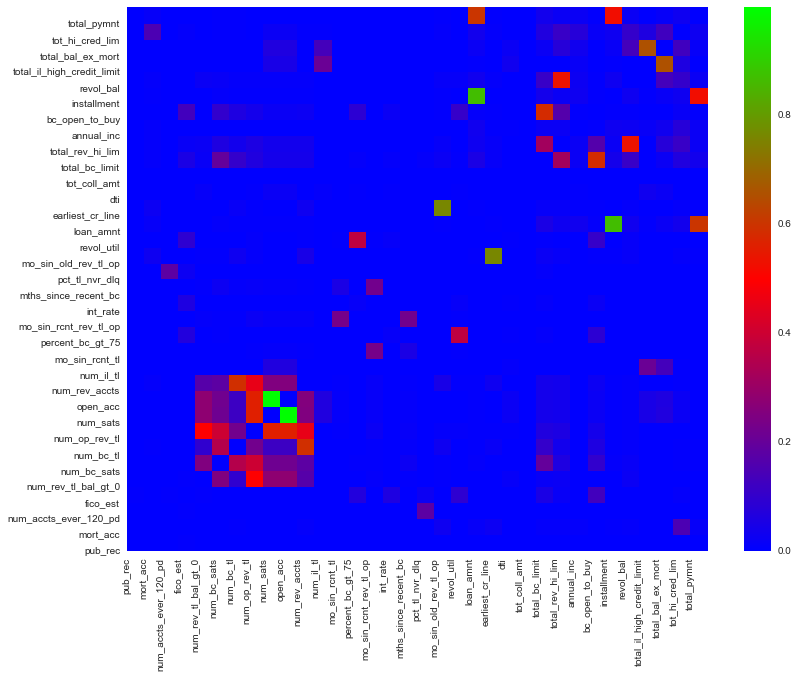

In [21]:
corr_df=nonnan_df[corr_columns]

matrix=np.corrcoef(corr_df,rowvar=False)-np.eye(len(corr_df.columns))


i,j=np.nonzero(abs(matrix) > 0.7)
print("Factors with high correlation (> +/-0.7) are:")
for k in range(len(i)):
    print("\t",k,corr_df.columns[i[k]],"vs",corr_df.columns[j[k]],"=",matrix[i[k]][j[k]])
    

# cube each value to highlight higher correlation elements
matrix=abs(matrix**3)
plt.figure(figsize=(13,10))
plt.pcolor(matrix,cmap='brg')

plt.xticks(range(len(corr_df.columns)), corr_df.columns,rotation='vertical')
plt.yticks(range(len(corr_df.columns)), corr_df.columns)
plt.colorbar(cmap='brg')
plt.show()

## Removing redundancy
We see that some of the factors in this dataset are two ways of measuring the same thing. For example, interest rates (`int_rate`) and the grading of the loan (`grade`) two ways of saying the same thing. A lower grade of loan indicates higher risk and higher risk is offset with a higher interest rate. Indeed, we see a large amount of correlation between the two fields.

As another example, we can see the percentage of bankcard accounts > 75% of the limit (`percent_bc_gt_75`) is highly correlated with the utilization of bank cards(`revol_bal`). Both of these are similar to the maximum amount of credit utilization (`total_rev_hi_lim`).

For this reason we need to select variables with high correlation and choose the variables that will have the biggest impact on our model. I have created the following groups that will need to be consolidated.

## High-Magnitude Factors
The following code regularizes the data and then looks for the regressor that, when considered independently has the higest impact on the model.

In [22]:
# Create standardized dataframe
std_df = nonnan_df.copy()
y=nonnan_df['total_pymnt']/nonnan_df['loan_amnt']
for col in std_df.columns:
    std_df[col] = (std_df[col] - std_df[col].min()) / (std_df[col].max() - std_df[col].min())
x_full=std_df.drop(columns=['loan_amnt','loan_amnt'])
# Revolving debt maximum related variables
revolving = [
    'bc_open_to_buy',
    'num_rev_accts',
    'num_rev_tl_bal_gt_0',
    'revol_bal',
    'revol_util',
    'total_rev_hi_lim',
    'tot_hi_cred_lim',
    'num_il_tl',
    'open_acc',
    'num_bc_tl'
]

test_df = pd.DataFrame(columns=['Predictor','ABS Coef','R2'])
for col in revolving:
    cols_to_drop = revolving.copy()
    cols_to_drop.remove(col)
    x=x_full.drop(columns=cols_to_drop)
    test_reg = LinearRegression().fit(x,y)
    test_coef = test_reg.coef_[list(x.columns).index(col)]
    test_score = test_reg.score(x,y)
    test_df = test_df.append({
        'Predictor':col,
        'ABS Coef':abs(test_coef),
        'R2':test_score
    },ignore_index=True)
test_df

,Predictor,ABS Coef,R2
0,bc_open_to_buy,0.164406,0.753054
1,num_rev_accts,0.030639,0.753032
2,num_rev_tl_bal_gt_0,0.017081,0.753023
3,revol_bal,0.168917,0.753023
4,revol_util,0.013918,0.753021
5,total_rev_hi_lim,0.703311,0.753041
6,tot_hi_cred_lim,0.053373,0.753023
7,num_il_tl,0.029726,0.753030
8,open_acc,0.397532,0.753034
9,num_bc_tl,0.012081,0.753021


By far, total Revolving Debt limit has the biggest impact in terms of magnitude. We should keep this as the one regressor to represent revolving debt. This will help us to eliminate multicolinearity. Let's explore the impact this has on our correlation matrix

Note:
I did not perform the same analysis for the grade and interest rate. The loans are structured so that the grade determines the range of interest rates. The steps within the grade specifically determine the interest rate. Therefore, the grade the step and the rate all give the same information, but the rate gives the specific detail.

Note: In the new dataset, I replace the payment amount with the percentage of income that is dedicated to the payment. We can have all the factors to calculate loan amount (term, rate, and original balance) as individual regressors. Replacing it will still capture a critical element of the loan amount while removing multicolinearity.

error removing grade
Factors with high correlation (> +/-0.7) are:
	 0 num_bc_sats vs num_op_rev_tl = 0.7353826032302152
	 1 num_op_rev_tl vs num_bc_sats = 0.7353826032302151
	 2 num_op_rev_tl vs num_sats = 0.8231132793215286
	 3 num_sats vs num_op_rev_tl = 0.8231132793215286
	 4 mo_sin_old_rev_tl_op vs earliest_cr_line = 0.9135129858317597
	 5 loan_amnt vs installment = 0.9529046887973828
	 6 loan_amnt vs total_pymnt = 0.8431383920994311
	 7 earliest_cr_line vs mo_sin_old_rev_tl_op = 0.9135129858317597
	 8 installment vs loan_amnt = 0.9529046887973829
	 9 installment vs total_pymnt = 0.8068253415728922
	 10 total_il_high_credit_limit vs total_bal_ex_mort = 0.8690587761071721
	 11 total_bal_ex_mort vs total_il_high_credit_limit = 0.869058776107172
	 12 total_pymnt vs loan_amnt = 0.8431383920994312
	 13 total_pymnt vs installment = 0.8068253415728923


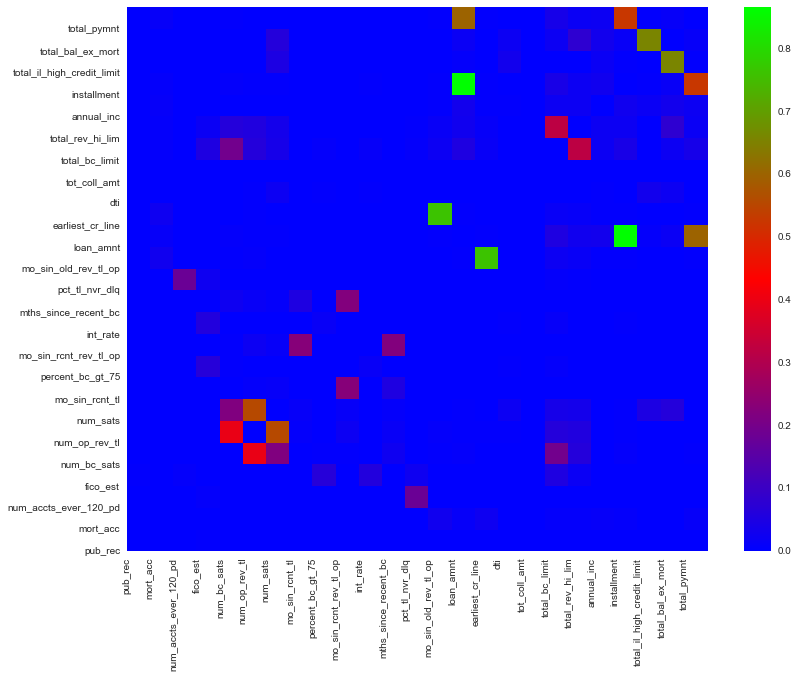

In [23]:
reduc_corr_columns = corr_columns.copy()

#reduc_corr_columns[]
to_remove = revolving.copy()
to_remove += ['grade'] # Extra code to drop grade

to_remove.remove('total_rev_hi_lim')
for x in to_remove:
    try:
        reduc_corr_columns.remove(x)
    except:
        print("error removing",x)

corr_df=nonnan_df[reduc_corr_columns]

matrix=np.corrcoef(corr_df,rowvar=False)-np.eye(len(corr_df.columns))


i,j=np.nonzero(abs(matrix) > 0.7)
print("Factors with high correlation (> +/-0.7) are:")
for k in range(len(i)):
    print("\t",k,corr_df.columns[i[k]],"vs",corr_df.columns[j[k]],"=",matrix[i[k]][j[k]])
    

# cube each value to highlight higher correlation elements
matrix=abs(matrix**3)
plt.figure(figsize=(13,10))
plt.pcolor(matrix,cmap='brg')

plt.xticks(range(len(corr_df.columns)), corr_df.columns,rotation='vertical')
plt.yticks(range(len(corr_df.columns)), corr_df.columns)
plt.colorbar(cmap='brg')
plt.show()

Notes:
- We still see some multicolinearity with the loan payment section. I plan to address additional factors in the factoring for income section.
- Total payments is one of the planned Y variables. For instances where it has high correlation, we expect to see strong relationships.


# Factoring for income
The correlation matrix emphasizes some factors in the data are highly correlated. In some instances, this correlation may be due to the fact that the predictors are dependent on other predictors. For example, we can consider three predictors in concert: the income, the loan repayment and the interest rate assigned by Lending Club. We are assuming that a higher amount of risk is related to a higher interest rate. That is to say, Lending Club assesses that loans are riskier based on loan to income ratio.

In [24]:
# Shows the relationship between loan repayment and income:
features = ['annual_inc','installment','int_rate']

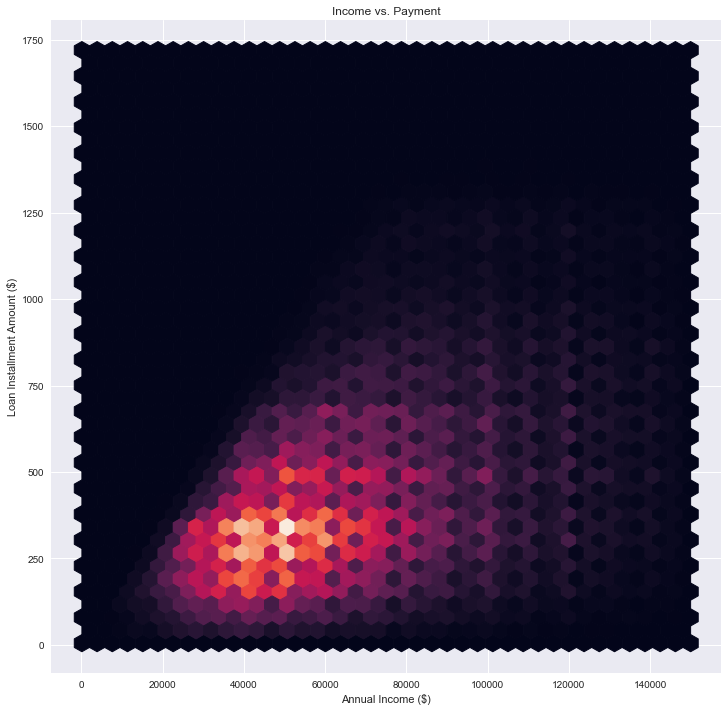

In [25]:
# Large outliers make the trend difficult to understand so I'm making a trimmed df
temp_df = nonnan_df[nonnan_df['annual_inc']<150000][['installment','annual_inc']]
x = temp_df['annual_inc']
y = temp_df['installment']
plt.figure(figsize=(12,12))
plt.hexbin(x,y,gridsize =40)
plt.xlabel('Annual Income ($)')
plt.ylabel('Loan Installment Amount ($)')
plt.title('Income vs. Payment')
plt.show()

While it looks like income and loan amount are both approximately normally distributed, we see that there is a clear fan pattern here. No monthly loan payment is larger than approximately 1% of annual income. We may be able to keep valuable information from both datasets and reduce multicolinearity by considering not the individuals variables, but the relationships between them.

In [26]:
nonnan_df['percent_of_income'] = nonnan_df['installment']*12/nonnan_df['annual_inc']
nonnan_df['percent_of_income'].describe()

count    890319.000000
mean          0.078960
std           0.058134
min           0.000123
25%           0.047090
50%           0.072569
75%           0.104865
max          31.792800
Name: percent_of_income, dtype: float64

Because we see some odd cases, I looked up an extreme and found that we see odd values when considering joint incomes. These instances are rare (fewer than 40 cases where total payments are greater than total income). This loan was funded as a joint application. As a result we are going to have to throw out any data about joint applications as it only represents 8000 cases, but creates significant leverage points.

In [27]:
# Testing an extreme example from the
df.iloc[1542746]

index                                                                                     18648
id                                                                                    115381037
member_id                                                                                   NaN
loan_amnt                                                                                 10000
funded_amnt                                                                               10000
funded_amnt_inv                                                                           10000
term                                                                                  60 months
int_rate                                                                                 20.00%
installment                                                                              264.94
grade                                                                                         D
sub_grade                               

In [28]:
# Additional factors to remove
if 'installment' not in to_remove:
    to_remove += ['installment']
    to_remove += ['total_pymnt','loan_amnt']
features = list(set(nonnan_df.columns) - set(to_remove))

# Let's work with training and test sets

In [29]:
print(df.shape,nonnan_df.shape)

# need to look at interest rate as well!!!
y=nonnan_df['total_pymnt']/(nonnan_df['installment']*36 + nonnan_df['installment']*nonnan_df['term_ 60 months']*24)
#y=nonnan_df['total_pymnt']/nonnan_df['loan_amnt']
print(features)
traintest_df=nonnan_df[features]

X_train, X_test, y_train, y_test = train_test_split(
    traintest_df,y,test_size=0.2,random_state=42)#,stratify=nonnan_df[['loan_status']])

Xscaler = StandardScaler()
Xscaler.fit_transform(X_train,X_test)

print(X_train.shape,X_test.shape)

(1873317, 153) (890319, 59)
['inq_last_6mths', 'mths_since_recent_bc', 'verification_status_Verified', 'tot_coll_amt', 'purpose_renewable_energy', 'purpose_home_improvement', 'delinq_2yrs', 'num_op_rev_tl', 'tax_liens', 'percent_of_income', 'percent_bc_gt_75', 'issue_d', 'chargeoff_within_12_mths', 'num_bc_sats', 'pct_tl_nvr_dlq', 'dti', 'purpose_debt_consolidation', 'purpose_other', 'total_il_high_credit_limit', 'pub_rec', 'int_rate', 'mo_sin_old_rev_tl_op', 'collections_12_mths_ex_med', 'purpose_small_business', 'emp_length', 'purpose_medical', 'term_ 60 months', 'application_type_Joint App', 'total_rev_hi_lim', 'total_bc_limit', 'home_ownership', 'mo_sin_rcnt_rev_tl_op', 'num_sats', 'purpose_major_purchase', 'verification_status_Source Verified', 'pub_rec_bankruptcies', 'purpose_house', 'total_bal_ex_mort', 'mort_acc', 'num_accts_ever_120_pd', 'earliest_cr_line', 'mo_sin_rcnt_tl', 'num_tl_90g_dpd_24m', 'annual_inc', 'fico_est', 'num_tl_op_past_12m']
(712255, 46) (178064, 46)


In [30]:
# your code here

pca = PCA(n_components=.95,svd_solver="full")
principalComponents = pca.fit(X_train)

print("PCA used %d components to capture >95%% variance."% len(pca.components_))
print("Total variance captured = %f." % pca.explained_variance_ratio_.sum())
#print(principalComponents.components_)

X_pca_train = pca.transform(X_train)
X_pca_test = pca.transform(X_test)


PCA used 3 components to capture >95% variance.
Total variance captured = 0.952527.


In [31]:
LCOLSModel = LinearRegression().fit(X_train, y_train)

print(LCOLSModel.intercept_)
print(LCOLSModel.coef_)

# your code here
trainR2 = r2_score(y_train,LCOLSModel.predict(X_train))

testR2 = r2_score(y_test,LCOLSModel.predict(X_test))

print("The training set OLS regression R^2 score is: %f" % trainR2)
print("The test set OLS regression R^2 score is: %f" % testR2)

80.08564247037769
[-4.56102421e-03  1.28294894e-04 -9.56595387e-03  1.87197408e-08
 -2.33998934e-02 -4.74986101e-03 -5.77587873e-03 -4.29149710e-04
 -4.27676759e-03 -5.74932659e-02 -1.94721622e-05 -3.92272948e-02
 -1.61637565e-03 -1.41599211e-03 -5.87489916e-04 -1.23335347e-03
 -1.64467743e-03 -1.84374113e-03  1.30486744e-07  4.39802834e-03
 -1.38481957e-02  1.39322006e-04 -7.54604438e-03 -3.76015624e-02
  1.03371141e-03 -1.82869780e-02 -1.39600904e-01  2.98083822e-02
  6.39841315e-08  1.51190003e-07  5.20541891e-04 -1.00787081e-04
  4.52664231e-04 -1.16807421e-02 -8.92484492e-03 -2.36643609e-03
 -6.22685821e-03 -4.75144786e-08  4.86373592e-03 -1.15664534e-03
 -3.68358965e-06  2.24310520e-04  2.98992185e-03 -4.93411518e-09
  9.59375192e-05 -4.03102381e-03]
The training set OLS regression R^2 score is: 0.236388
The test set OLS regression R^2 score is: 0.259335


In [32]:
lambdas = [.001, .005, 1, 5, 10, 50, 100, 500, 1000]

kfold = KFold(5, shuffle=True) # use this for testing

LCRRModel = RidgeCV(alphas=lambdas, cv=kfold)
LCRRModel.fit(X_train, y_train)
LCRR_shrinkage_parameter=LCRRModel.alpha_

print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(LCRR_shrinkage_parameter,
                                                                            LCRRModel.intercept_,
                                                                            LCRRModel.coef_
                                                                            )
     )

RRtrainR2 = r2_score(y_train,LCRRModel.predict(X_train))
RRtestR2 = r2_score(y_test,LCRRModel.predict(X_test))
print("The training set Ridge regression R^2 score is: %f" % RRtrainR2)
print("The test set Ridge regression R^2 score is: %f" % RRtestR2)

Best model searched:
alpha = 1000
intercept = 79.90183076735184
betas = [-4.44812882e-03  1.27470286e-04 -9.79234275e-03  1.88900358e-08
 -5.14840025e-03  8.86441233e-04 -5.70803385e-03 -4.38048763e-04
 -3.96764899e-03 -3.75741020e-02 -1.56485150e-05 -3.91369188e-02
 -1.39822547e-03 -1.41460177e-03 -5.90519025e-04 -1.27140581e-03
  3.80921407e-03  4.27781496e-03  1.34367650e-07  4.12830900e-03
 -1.39958381e-02  1.38744852e-04 -7.04899106e-03 -2.76811461e-02
  1.03426527e-03 -1.05141098e-02 -1.37893827e-01  2.46231844e-02
  6.51311701e-08  1.45248441e-07  4.92943416e-04 -9.81543858e-05
  4.54205880e-04 -5.39824487e-03 -9.13745205e-03 -2.03400000e-03
  3.27024086e-05 -4.84095971e-08  4.84762939e-03 -1.15128611e-03
 -3.67471880e-06  2.18789905e-04  2.89204753e-03 -4.10513130e-09
  9.14656270e-05 -3.93009820e-03], 
The training set Ridge regression R^2 score is: 0.236355
The test set Ridge regression R^2 score is: 0.259211


In [33]:
LCLRModel = LassoCV(alphas=lambdas, cv=kfold)
LCLRModel.fit(X_train, y_train)
LCLR_shrinkage_parameter = LCLRModel.alpha_
print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(LCLR_shrinkage_parameter,
                                                                            LCLRModel.intercept_,
                                                                            LCLRModel.coef_
                                                                            )
     )

LRtrainR2 = r2_score(y_train,LCLRModel.predict(X_train))
LRtestR2 = r2_score(y_test,LCLRModel.predict(X_test))
print("The training set Lasso regression R^2 score is: %f" % LRtrainR2)
print("The test set Lasso regression R^2 score is: %f" % LRtestR2)

Best model searched:
alpha = 0.001
intercept = 78.17905520348548
betas = [-2.97175645e-03  1.22756705e-04 -3.06687362e-05  1.70526419e-08
 -0.00000000e+00 -0.00000000e+00 -2.81455397e-03 -1.34212363e-04
 -0.00000000e+00 -0.00000000e+00  9.55460900e-06 -3.82891910e-02
 -0.00000000e+00 -1.16822640e-03 -4.03347059e-04 -1.29453254e-03
  0.00000000e+00  0.00000000e+00  1.36211560e-07  0.00000000e+00
 -1.47649457e-02  1.36175769e-04 -0.00000000e+00 -0.00000000e+00
  9.44301487e-04 -0.00000000e+00 -1.31212783e-01  0.00000000e+00
  6.07083668e-08  9.69072217e-08 -0.00000000e+00 -7.47218612e-05
  4.45307581e-05 -0.00000000e+00 -7.22997903e-04  0.00000000e+00
 -0.00000000e+00 -4.17152182e-08  4.45871137e-03 -0.00000000e+00
 -3.60050471e-06  1.96867404e-04 -0.00000000e+00 -8.62982906e-09
  9.06274380e-05 -3.50176619e-03], 
The training set Lasso regression R^2 score is: 0.235360
The test set Lasso regression R^2 score is: 0.257991


In [34]:
coef_df=pd.DataFrame(np.array([X_train.columns,
                               LCOLSModel.coef_,
                               LCRRModel.coef_,
                               LCLRModel.coef_]).T,columns=["feature","OLS","RR","LR"])

In [35]:
print(coef_df)

                                feature          OLS           RR           LR
0                        inq_last_6mths  -0.00456102  -0.00444813  -0.00297176
1                  mths_since_recent_bc  0.000128295   0.00012747  0.000122757
2          verification_status_Verified  -0.00956595  -0.00979234 -3.06687e-05
3                          tot_coll_amt  1.87197e-08    1.889e-08  1.70526e-08
4              purpose_renewable_energy   -0.0233999   -0.0051484           -0
5              purpose_home_improvement  -0.00474986  0.000886441           -0
6                           delinq_2yrs  -0.00577588  -0.00570803  -0.00281455
7                         num_op_rev_tl  -0.00042915 -0.000438049 -0.000134212
8                             tax_liens  -0.00427677  -0.00396765           -0
9                     percent_of_income   -0.0574933   -0.0375741           -0
10                     percent_bc_gt_75 -1.94722e-05 -1.56485e-05  9.55461e-06
11                              issue_d   -0.0392273

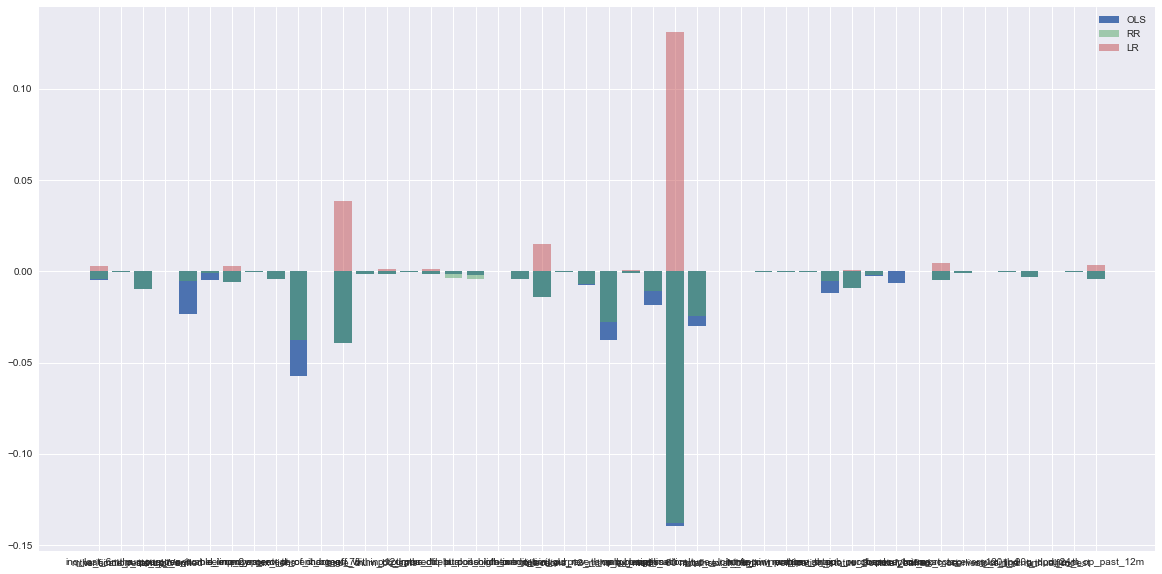

In [36]:
# your code here
plt.figure(figsize=(20,10))
plt.bar(coef_df["feature"],-abs(coef_df["OLS"]),label='OLS',alpha=1.0)
plt.bar(coef_df["feature"],-abs(coef_df["RR"]),label='RR',alpha=0.5)
plt.bar(coef_df["feature"],abs(coef_df["LR"]),label='LR',alpha=0.5)
plt.yscale("linear")

plt.legend()
plt.show()

## Additional Multicolinearity Analysis
Based on the poor performance of the models. I performed additional analysis to determine the impact of multicolinearity on our data. Note: Based on this analysis, I simplified some of the dummy variables.

In [37]:

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.columns.shape[0])]
vif['Feature'] = X_train.columns
vif.sort_values('VIF',ascending=False)


,VIF,Feature
11,1330.421556,issue_d
44,1057.396336,fico_est
14,252.543863,pct_tl_nvr_dlq
16,88.361632,purpose_debt_consolidation
40,37.410327,earliest_cr_line
21,31.368786,mo_sin_old_rev_tl_op
32,28.597234,num_sats
7,26.818020,num_op_rev_tl
37,20.054200,total_bal_ex_mort
20,18.280542,int_rate


In [38]:
corval = []
for i in X_train.columns:
    if not i == 'issue_d':
        print(i, np.corrcoef(X_train['issue_d'],X_train[i])[0][1])
        corval += [np.corrcoef(X_train['issue_d'],X_train[i])[0][1]]
print(max(corval))

inq_last_6mths -0.07558269913526022
mths_since_recent_bc -0.041462877159529246
verification_status_Verified -0.1016814081406516
tot_coll_amt 0.004858508727295104
purpose_renewable_energy 0.0018919679346384376
purpose_home_improvement 0.038823458495838174
delinq_2yrs 0.022207023343856644
num_op_rev_tl 0.017810450433536327
tax_liens 0.03351866235405846
percent_of_income -0.03030371515645041
percent_bc_gt_75 -0.14691459985841218
chargeoff_within_12_mths 0.006156011553700833
num_bc_sats 0.022320291544429955
pct_tl_nvr_dlq -0.045857922546332586
dti 0.04492240737403116
purpose_debt_consolidation -0.07284738923537105
purpose_other 0.04634575172725894
total_il_high_credit_limit 0.09256538949671332
pub_rec 0.06898282020764816
int_rate -0.03423331009423411
mo_sin_old_rev_tl_op -0.009181311517780892
collections_12_mths_ex_med 0.03926947396513805
purpose_small_business -0.0022850475504016094
emp_length -0.015775259088954278
purpose_medical 0.020344296223133725
term_ 60 months 0.011764257245841262


# Advanced Models
We continue to have problems with multicolinearity which may be contributing to some of the problems we are seeing in the data. I am going to try additional models that may be more suitable.

Because of the sheer size of our dataset, the following block of code take a long time to run. I ran one with full datasets without much luck. To reduce the runtime, I pulled a random sample from the dataset.

In [39]:
sample_percent = .01 # I put this ridiculouly low to ensure code would compile. I will run again overnight with a 
# larger number for additional insights.
X_train_sample = X_train.reset_index(drop=True).sample(int(len(X_train)*sample_percent),random_state=42)
y_train_sample = y_train.reset_index(drop=True).iloc[X_train_sample.index]

In [40]:
neu_net = Sequential([
    Dense(800, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(400, activation='relu'),
    Dense(400, activation='relu'),
    Dense(400, activation='relu'),
    Dense(400, activation='relu'),
    Dense(1, activation='relu')
])
neu_net.compile(loss='mean_absolute_error', optimizer='adam')
neu_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 800)               37600     
_________________________________________________________________
dense_2 (Dense)              (None, 400)               320400    
_________________________________________________________________
dense_3 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_5 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 401       
Total params: 839,601
Trainable params: 839,601
Non-trainable params: 0
_________________________________________________________________


In [41]:
neu_net.fit(X_train_sample,y_train_sample, epochs=20, batch_size=64, validation_split = .25)


Train on 5341 samples, validate on 1781 samples
Epoch 1/20
5341/5341 [==============================] - 2s 325us/step - loss: 11.7374 - val_loss: 0.8184
Epoch 2/20
5341/5341 [==============================] - 1s 249us/step - loss: 0.8217 - val_loss: 0.8184
Epoch 3/20
5341/5341 [==============================] - 1s 245us/step - loss: 0.8217 - val_loss: 0.8184
Epoch 4/20
5341/5341 [==============================] - 1s 250us/step - loss: 0.8217 - val_loss: 0.8184
Epoch 5/20
5341/5341 [==============================] - 1s 247us/step - loss: 0.8217 - val_loss: 0.8184
Epoch 6/20
5341/5341 [==============================] - 1s 248us/step - loss: 0.8217 - val_loss: 0.8184
Epoch 7/20
5341/5341 [==============================] - 1s 244us/step - loss: 0.8217 - val_loss: 0.8184
Epoch 8/20
5341/5341 [==============================] - 1s 249us/step - loss: 0.8217 - val_loss: 0.8184
Epoch 9/20
5341/5341 [==============================] - 1s 246us/step - loss: 0.8217 - val_loss: 0.8184
Epoch 10/20
534

I don't see an improvement in the loss function. I'm going to try alternative methods.

In [42]:
RF_model = RandomForestRegressor(10)
RF_model.fit(X_train_sample,y_train_sample)
RF_model.score(X_test,y_test)

0.15175028760447629

In [43]:
size = []
avg_score = []
sd_score = []
for i in range(2,15):
    s = i * 4
    size += [s]
    RF_model = RandomForestRegressor(s)
    cv = cross_val_score(RF_model,X_train_sample,y_train_sample,cv=6)
    avg_score +=  [np.average(cv)]
    sd_score += [np.std(cv)]
    print(i,'complete')
    

2 complete
3 complete
4 complete
5 complete
6 complete
7 complete
8 complete
9 complete
10 complete
11 complete
12 complete
13 complete
14 complete


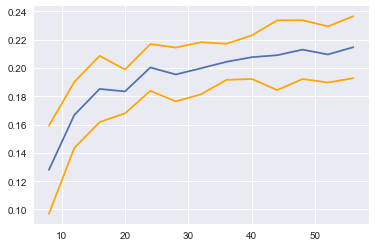

In [44]:
plt.plot(size,avg_score)
bound = []
for i in range(len(size)):
    bound += [avg_score[i]+sd_score[i]]
plt.plot(size,bound,c='orange')

bound = []
for i in range(len(size)):
    bound += [avg_score[i]-sd_score[i]]
plt.plot(size,bound,c='orange')

# Code for cleanup in the future

In [45]:
order=sorted(has_data, key=lambda dict_key: has_data[dict_key])

for i in order:
    print(i, has_data[i])

annual_inc_joint 9529
dti_joint 9529
mths_since_last_record 172185
mths_since_recent_bc_dlq 240759
mths_since_last_major_derog 264308
mths_since_rcnt_il 289098
all_util 296067
inq_last_12m 296092
open_acc_6m 296092
total_cu_tl 296092
inq_fi 296093
open_il_12m 296093
open_il_24m 296093
open_rv_12m 296093
open_rv_24m 296093
mths_since_recent_revol_delinq 338379
mths_since_last_delinq 503506
mths_since_recent_inq 881746
mo_sin_old_il_acct 924972
pct_tl_nvr_dlq 952881
mo_sin_old_rev_tl_op 953024
mo_sin_rcnt_rev_tl_op 953024
num_rev_accts 953024
mo_sin_rcnt_tl 953025
num_accts_ever_120_pd 953025
num_bc_tl 953025
num_il_tl 953025
num_op_rev_tl 953025
num_rev_tl_bal_gt_0 953025
num_tl_90g_dpd_24m 953025
num_tl_op_past_12m 953025
tot_coll_amt 953025
tot_hi_cred_lim 953025
total_il_high_credit_limit 953025
total_rev_hi_lim 953025
percent_bc_gt_75 962805
bc_open_to_buy 963125
mths_since_recent_bc 963842
num_bc_sats 964711
num_sats 964711
emp_length 965386
mort_acc 973271
total_bal_ex_mort 973271

# Heat map Visualizations

In [46]:
#Explore the loan status versus purpose
import seaborn as sns; sns.set()

purp_loan= ['purpose', 'loan_status']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[purp_loan[0]], df[purp_loan[1]]).style.background_gradient(cmap = cm)

loan_status,Charged Off,Current,Default,Does not meet the credit policy. Status:Charged Off,Does not meet the credit policy. Status:Fully Paid,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
purpose,,,,,,,,,
car,1621,8918,0,13,51,9496,95,35,166
credit_card,38804,185798,7,69,271,182070,2503,813,3511
debt_consolidation,129606,449458,10,292,808,470267,8431,2766,11680
educational,56,1,0,32,65,270,0,0,0
home_improvement,11703,58019,3,71,143,53007,859,295,1249
house,1089,4832,0,11,33,4072,88,34,126
major_purchase,4047,19217,0,23,100,17818,259,108,468
medical,2535,10865,0,22,36,8669,169,69,266
moving,1715,5464,1,15,31,5486,118,38,165


In [47]:
# Explore the loan status versus loan grade
loan_grade = ['loan_status', 'grade']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[loan_grade[0]], df[loan_grade[1]]).style.background_gradient(cmap = cm)

grade,A,B,C,D,E,F,G
loan_status,,,,,,,
Charged Off,10831,40038,64493,47643,29714,12257,3681
Current,150647,252131,250946,105350,39290,10482,3348
Default,0,5,14,2,2,1,0
Does not meet the credit policy. Status:Charged Off,8,85,148,197,158,93,72
Does not meet the credit policy. Status:Fully Paid,90,269,481,494,378,154,122
Fully Paid,160994,254370,222484,108832,46641,14794,3780
In Grace Period,765,2929,4902,2934,1447,469,188
Late (16-30 days),252,963,1602,1011,520,186,68
Late (31-120 days),1032,3884,6880,4292,2222,871,354


In [48]:
#Explore the loan status versus home ownership
loan_home = ['loan_status', 'home_ownership']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[loan_home[0]], df[loan_home[1]]).style.background_gradient(cmap = cm)


home_ownership,ANY,MORTGAGE,NONE,OTHER,OWN,RENT
loan_status,,,,,,
Charged Off,33,89406,7,27,22586,96598
Current,341,399110,1,0,95966,316776
Default,0,8,0,0,2,14
Does not meet the credit policy. Status:Charged Off,0,348,1,11,49,352
Does not meet the credit policy. Status:Fully Paid,0,908,4,27,138,911
Fully Paid,124,417473,40,117,83520,310621
In Grace Period,6,6421,1,0,1592,5614
Late (16-30 days),0,2148,0,0,605,1849
Late (31-120 days),8,8282,0,0,2481,8764


In [49]:
#Exploring the loan_status versus loan application_type
loan_application = ['loan_status', 'application_type']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[loan_application[0]], df[loan_application[1]]).style.background_gradient(cmap = cm)

application_type,Individual,Joint App
loan_status,,
Charged Off,206689,1968
Current,756226,55968
Default,23,1
Does not meet the credit policy. Status:Charged Off,761,0
Does not meet the credit policy. Status:Fully Paid,1988,0
Fully Paid,804334,7561
In Grace Period,12553,1081
Late (16-30 days),4278,324
Late (31-120 days),18382,1153


In [50]:
#Exploring the State Address versus Loan Status
adress_loan = ['addr_state', 'loan_status']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[adress_loan[0]], df[adress_loan[1]]).style.background_gradient(cmap = cm)

loan_status,Charged Off,Current,Default,Does not meet the credit policy. Status:Charged Off,Does not meet the credit policy. Status:Fully Paid,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
addr_state,,,,,,,,,
AK,504,1846,0,1,4,2021,34,6,53
AL,3109,9644,0,8,24,9630,178,64,270
AR,1869,6123,0,6,9,5752,99,36,173
AZ,4950,18364,0,18,33,19889,309,101,498
CA,30436,104027,5,101,223,122155,1655,588,2663
CO,3626,16037,0,13,52,19244,209,85,306
CT,2623,14159,0,12,50,12043,271,89,283
DC,367,1729,0,2,8,2386,36,11,32
DE,570,2339,0,4,18,2233,51,16,75


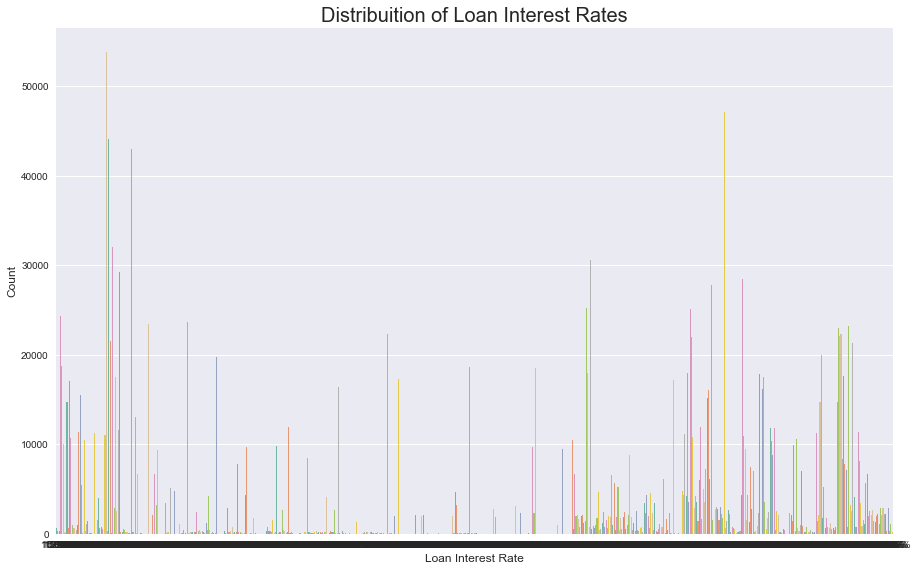

In [51]:
# Explore distrubution of loan interest rates
plt.figure(figsize = (15,12))
plt.subplot(211)
g1 = sns.countplot(x="int_rate",data=df, 
                   palette="Set2")
g1.set_xlabel("Loan Interest Rate", fontsize=12)
g1.set_ylabel("Count", fontsize=12)
g1.set_title("Distribuition of Loan Interest Rates", fontsize=20)

plt.subplots_adjust(wspace = 0.4, hspace = 1.2,top = 2)

plt.show()

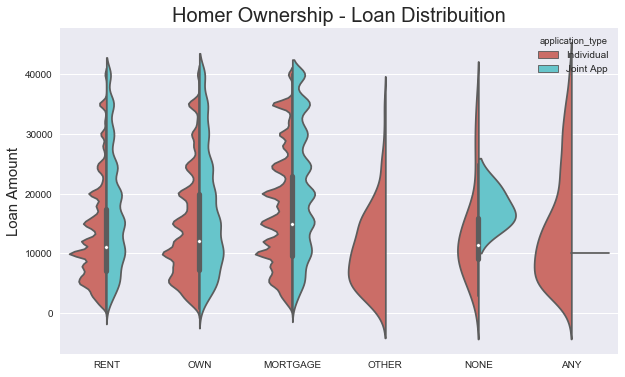

In [ ]:
plt.figure(figsize = (10,6))

g = sns.violinplot(x="home_ownership",y="loan_amnt",data=df,
               kind="violin",
               split=True,palette="hls",
               hue="application_type")
g.set_title("Homer Ownership - Loan Distribuition", fontsize=20)
g.set_xlabel("", fontsize=15)
g.set_ylabel("Loan Amount", fontsize=15)

plt.show()

In [ ]:
# Explore Loan Purpose
print("Purposes count description: ")
print(pd.crosstab(df.purpose, df.application_type))

plt.figure(figsize = (12,8))

plt.subplot(211)
g = sns.countplot(x="purpose",data=df,
                  palette='hls')
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Application Type - Loan Amount", fontsize=20)
g.set_xlabel("", fontsize=15)
g.set_ylabel("Loan Amount", fontsize=15)

plt.subplot(212)
g1 = sns.violinplot(x="purpose",y="loan_amnt",data=df,
               hue="application_type", split=True)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_title("Application Type - Loan Amount", fontsize=20)
g1.set_xlabel("", fontsize=15)
g1.set_ylabel("Loan Amount", fontsize=15)

plt.subplots_adjust(wspace = 0.2, hspace = 0.8,top = 0.9)
plt.show()

Purposes count description: 
application_type    Individual  Joint App
purpose                                  
car                      19829        566
credit_card             401026      12820
debt_consolidation     1031471      41847
educational                424          0
home_improvement        120451       4898
house                     9988        297
major_purchase           40716       1324
medical                  21452       1179
moving                   12570        463
other                   110453       3703
renewable_energy          1195         38
small_business           20836        616
vacation                 12469        304
wedding                   2354          1


In [ ]:
plt.figure(figsize = (12,6))

g = sns.violinplot(x='loan_status', y="installment",
                   data=df)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Installment Distrubution", fontsize=15)
g.set_title("Loan Status by Installment", fontsize=20)

plt.show()

In [ ]:
df.loc[df.loan_status == \
            'Does not meet the credit policy. Status:Fully Paid', 'loan_status'] = 'NMCP Fully Paid'
df.loc[df.loan_status == \
            'Does not meet the credit policy. Status:Charged Off', 'loan_status'] = 'NMCP Charged Off'

In [ ]:
print(df.loan_status.value_counts())

plt.figure(figsize = (18,21))

plt.subplot(311)
g = sns.countplot(x="loan_status", data=df)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=15)
g.set_title("Loan Status Count", fontsize=20)

plt.subplot(312)
g1 = sns.boxplot(x="loan_status", y="total_acc", data=df)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("", fontsize=12)
g1.set_ylabel("Total Acc", fontsize=15)
g1.set_title("Duration Count", fontsize=20)

plt.subplot(313)
g2 = sns.violinplot(x="loan_status", y="loan_amnt", data=df)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)
g2.set_xlabel("Duration Distribuition", fontsize=15)
g2.set_ylabel("Count", fontsize=15)
g2.set_title("Loan Amount", fontsize=20)

plt.subplots_adjust(wspace = 0.2, hspace = 0.7,top = 0.9)

plt.show()